# 2019 07 25
## Testing cin pulse alternate 


In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%matplotlib inline
output_notebook()

# you need to populate image lists from the two folders

# file_temp = "/mnt/disks/movie-181208/180827_1/{}/img_{:09d}_{}_000.tif"

Loading BokehJS ...

In [2]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def img_metadata_dict(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        This function uses string replacements to read dictionary key-value pairs.
    
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        After some cleanup, this function reads the metadata string directly as a dictionary definition.
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','False').replace('true','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Wrapper for reading creation time from an image filename'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Wrapper for reading full metadata dictionary from a filename'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'][:-6],r"%Y-%m-%d %H:%M:%S")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [3]:
super_dir = '../data'
pos_dirs = [os.path.join(super_dir, xx) for xx in os.listdir(super_dir) if os.path.isdir(os.path.join(super_dir, xx))]
img_files = [os.path.join(pos_dir, xx) for pos_dir in pos_dirs for xx in os.listdir(pos_dir) if '.tif' in xx]
img_re_pattern = '{}/(?P<pad>[0-9]*)?(?(pad)-Pos_(?P<padpos>[0-9]*)_000|Pos(?P<pos>[0-9]*))/img_(?P<frame>[0-9]*)_(?P<channel>[0-9]*)_000.tif'.format(super_dir)

In [4]:
# Extract movie metadata
all_metadata = fn_metadata_full(img_files[0])
summ_dict = all_metadata['Summary']
chan_ind = summ_dict['ChNames']
chan_int = [int(xx) for xx in chan_ind]
n_chan = len(chan_ind)
chan_int_dict = dict(zip(chan_int, np.arange(n_chan)))
chan_name = [all_channel_dict[xx] for xx in chan_ind]
n_pos = len(pos_dirs)#summ_dict['Positions']
im_width = summ_dict['Width']
im_height = summ_dict['Height']

rem = re.findall(img_re_pattern, '\n'.join(img_files), re.MULTILINE)
rem_arr = np.array(rem)
rem_arr[rem_arr==''] = -1
metadata_arr = rem_arr.astype(np.int)
n_rows = metadata_arr.shape[0]
pad_vec, padpos_vec, pos_vec, frame_vec, channel_vec = metadata_arr.T
pad_vec = pad_vec - 1
time_vec = np.array([ctime(xx) for xx in img_files])
time_vec = time_vec - time_vec.min()
pos_vec = np.empty(n_rows)

n_frames = 96

columns = ['pos','padpos','pad','frame','channel','fn','time']
n_rows = len(img_files)
n_pads = 5

files_df = pd.read_csv('filesdf.csv')

# files_df = pd.DataFrame(
#     dict(zip(columns, [pos_vec, padpos_vec, pad_vec, frame_vec, channel_vec, img_files, time_vec])))
# files_df = files_df.sort_values(by='time')
# files_df = files_df.loc[files_df.frame<96,:]
# files_df.loc[:,'pos'] = np.tile(np.repeat(np.arange(n_pos), n_chan), n_frames)

# def pad_helper_fn(pos):
#     pad_lims = np.array([8,19,32,44,56])
#     pad_inds = np.arange(len(pad_lims))
#     return np.min(pad_inds[pad_lims > pos])

# files_df.loc[:,'pad'] = np.array([pad_helper_fn(xx) for xx in files_df.pos.values])

# gb_pad = files_df.groupby('pad')
# for pad_ind in np.arange(n_pads):
#     pad_inds = gb_pad.get_group(pad_ind).index
#     files_df.loc[pad_inds,'padpos'] = files_df.loc[pad_inds,'pos'] - files_df.loc[pad_inds,'pos'].min() 

pos_df = files_df.loc[:,['pos','pad','padpos']].groupby('pos').agg(np.min)
# files_df.to_csv('filesdf.csv',index=False)

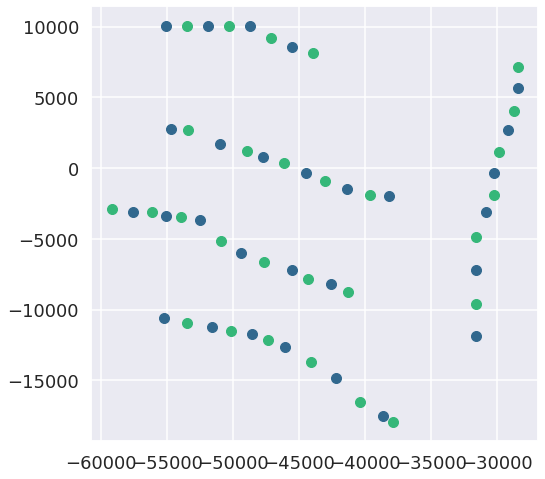

In [5]:

# Cor_pos_df is corrected position DF. In this notebook, correcting the position is not
# necessary as there are only two imaging positions per pad. DF also includes inducer info
# 0, 1, 2 for inducers blank, C, R; respectively
columns = ['x','y','label','padpos', 'pad', 'dist']
n_cols = len(columns)
cor_pos_df = pd.DataFrame(np.empty((n_pos,n_cols)), columns=columns, index=np.arange(n_pos))
for pos in np.arange(n_pos):
    x, y = summ_dict['InitialPositionList'][pos]['DeviceCoordinatesUm']['XYStage']
    label = summ_dict['InitialPositionList'][pos]['Label']
    pad, padpos = pos_df.loc[pos,['pad', 'padpos']]
    cor_pos_df.loc[pos,['x', 'y', 'label', 'pad', 'padpos']] = [x, y, label, pad, padpos]
#     files_df.loc[files_df.pos==p_i,'x'] = x
#     files_df.loc[files_df.pos==p_i,'y'] = y

# cor_pos_df.sort_values(by=['pad','padpos'], inplace=True)
    
for p_i in np.arange(n_pos):
    pad = cor_pos_df.loc[p_i,['pad']].values[0]
    pad_xy = cor_pos_df.loc[(cor_pos_df.pad==pad),['x','y']].iloc[0,:].values
    pos_xy = cor_pos_df.loc[p_i,['x','y']].values
    dist = np.sqrt(np.power(pad_xy - pos_xy,2).sum())
    cor_pos_df.loc[p_i, 'dist'] = dist
    
def dist_f(pad_ind):
    '''
    Calculates distance between colonies for input pad index
    '''
    pos_arr = cor_pos_df.loc[cor_pos_df.pad == 3, ['x', 'y']].values
    dist = np.sqrt(np.sum(np.power(np.diff(pos_arr, axis=0),2)))
    return dist
    
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('viridis', n_colors=2)
    point_color = colors[np.int(np.mod(cor_pos_df.loc[p_i,"pad"],2))]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.label[p_i],
             ms=20,
             c=colors[np.mod(p_i,2)])
plt.show()
# plt.legend()

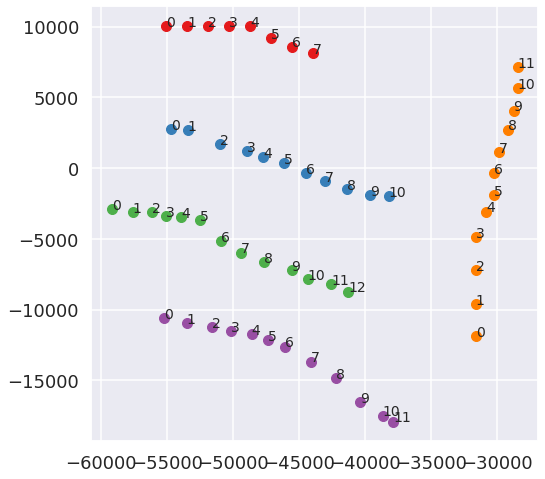

In [6]:
n_pads=5
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('Set1', n_colors=n_pads)
    point_color = colors[np.int(cor_pos_df.loc[p_i,"pad"])]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.pad[p_i],
             ms=20,
             c=point_color)
    plt.text(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '{}'.format(np.int(cor_pos_df.padpos[p_i])),
#              '{}'.format(p_i),
             fontsize=14)

In [113]:
# sorted_fdf = files_df.sort_values(by=['frame', 'pos', 'channel'])
# print(sorted_fdf)

# quickly just sum all of the fluorescence channels

def par_worker(fdf_sub, fn_out):
    df_index = fdf_sub.index
    n_rows, _ = fdf_sub.shape
    columns = ['pos', 'frame', 'channel', 'sum', 'time']
    n_col = len(columns)
    out_df = pd.DataFrame(np.zeros((n_rows, n_col),dtype=np.int), columns=columns, index=df_index)
    for i in df_index:
        pos, frame, channel, fn, time = fdf_sub.loc[i,['pos', 'frame', 'channel', 'fn', 'time']]
        im = skimage.io.imread(fn)
        img_sum = im.sum().sum()
        out_df.loc[i,:] = np.array([pos, frame, channel, img_sum, time], dtype=np.int)
    out_df.to_csv(fn_out)

fdf_fluor = files_df.loc[files_df.channel > 0,:]
fn_outs = ["worker_outputs/frame_sum_par_{}.csv".format(xx) for xx in range(4)]

# jobs = []
# for i in [0,1,2,3]:
#     p = multiprocessing.Process(target=par_worker, 
#                                 args=(fdf_fluor.iloc[i::4,:], fn_outs[i]))
#     jobs.append(p)
#     p.start()
# for j in jobs:
#     j.join()
# print("Done!")


In [114]:
all_data = pd.concat([pd.read_csv(fn, index_col=0) for fn in fn_outs])
sub_chan = len(np.unique(all_data.channel.values))
sub_pos = len(np.unique(all_data.pos.values))
all_data.sort_values(by='time', inplace=True)
pos_to_pad = files_df.loc[:,['pad', 'padpos', 'pos']].groupby('pos').agg(np.min)
meta_cols = pd.concat([cor_pos_df.loc[[xx],['pad','padpos', 'dist']] for xx in all_data.pos.values])
all_data = all_data.assign(pad=meta_cols.pad.values)
all_data = all_data.assign(padpos=meta_cols.padpos.values)
all_data = all_data.assign(dist=meta_cols.dist.values)

1100000000.0


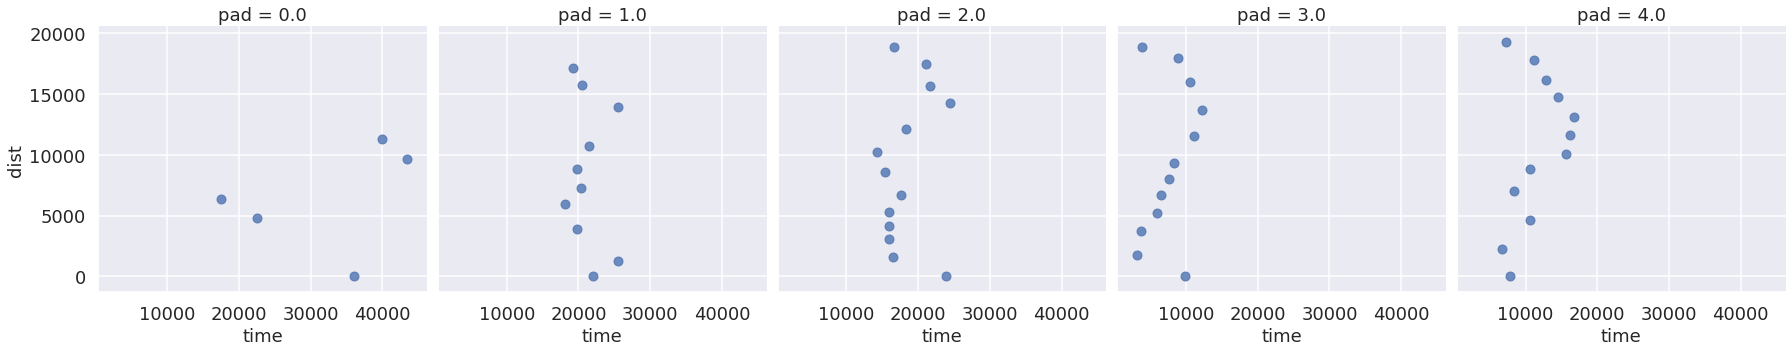

In [115]:
sub_df = all_data.loc[all_data.channel==5,["pos", 'frame', 'sum','pad','padpos','time','dist']]
arr = sub_df.loc[:,['pos','frame','sum']].pivot(values='sum',index='pos',columns='frame').values
thresh = skimage.filters.threshold_otsu(arr.astype(np.float))
thresh=1.1e9
thresh_df = sub_df.loc[sub_df.loc[:,'sum'] > thresh, ['pos','frame','pad','padpos','time','dist']].groupby('pos').agg(np.min)
# thresh_df
print(thresh)
# plt.imshow(arr, aspect=1/10)
g = sns.lmplot(data=thresh_df, x='time', y='dist', fit_reg=False, sharey=True, col='pad')
# g = sns.lmplot(data=sub_df, x='frame', y='sum', hue='padpos', fit_reg=False, sharey=False, col='pad')

1.2398844136483422um/s
1.097009850266534um/s


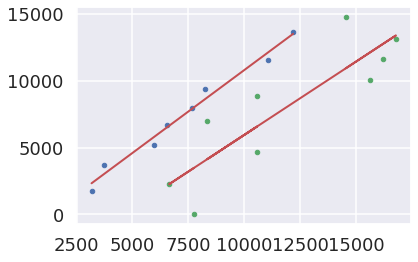

In [135]:
# sub_df = all_data.loc[all_data.channel==5,["pos", 'frame', 'sum','pad','padpos','time','dist']]
sub_df = thresh_df.loc[(thresh_df.pad==3)&(thresh_df.padpos<9)&(thresh_df.padpos>0),:]
x, y = sub_df.loc[:,['time', 'dist']].values.T

def fit_fun(t, a, b):
    return a*t + b

out = scp.optimize.curve_fit(fit_fun, x, y, np.array([0.5, 0]))
print("{}um/s".format(out[0][0]))
plt.plot(sub_df.time, sub_df['dist'],'.b')
plt.plot(x, fit_fun(x,*out[0]),'-r')
sub_df = thresh_df.loc[(thresh_df.pad==4)&(thresh_df.padpos<9),:]
x, y = sub_df.loc[:,['time', 'dist']].values.T
out = scp.optimize.curve_fit(fit_fun, x, y, np.array([0.5, 0]))
plt.plot(sub_df.time, sub_df['dist'],'.g')
plt.plot(x, fit_fun(x,*out[0]),'-r')
print("{}um/s".format(out[0][0]))

In [116]:
# all_data = pd.concat([pd.read_csv(fn, index_col=0) for fn in fn_outs])
# sub_chan = len(np.unique(all_data.channel.values))
# sub_pos = len(np.unique(all_data.pos.values))
# all_data.sort_values(by='time', inplace=True)
# re-make the frame columns
# all_data.loc[:,'frame'] = np.argsort(all_data.loc[:,'time'])//(sub_chan*sub_pos)

meta_cols = ['x', 'y', 'pad']
index = all_data.index
meta_df = pd.DataFrame(np.empty((all_data.shape[0], len(meta_cols))), index=all_data.index, columns=meta_cols)
for i in cor_pos_df.index:
    pos, x, y, pad = cor_pos_df.loc[i, ['pos', 'x', 'y', 'pad']]
    meta_df.loc[all_data.pos == pos,:] = np.array([x, y, pad])

df = pd.concat([all_data, meta_df], axis=1)
normed_df = df.copy()
bg_pos = df.loc[df.pos==9,:]
for channel in [3,5]:
    for frame_ind in np.arange(n_frames):
        ind = (normed_df.frame==frame_ind)&(normed_df.channel==channel) 
        bg_val = 0#bg_pos.loc[(bg_pos.frame==frame_ind)&(bg_pos.channel==channel),'sum'].values
        normed_df.loc[ind,'sum'] = normed_df.loc[ind,'sum'] - bg_val
# g = sns.lmplot(data=all_data, x='time', y='sum', hue='channel',row='padpos', fit_reg=False, sharey=True, col='pad')
# g.axes[0,0].set_title('RFP Strain 0')
# g.axes[0,1].set_title('RFP Strain 1')
# g.axes[0,2].set_title('RFP Strain 2')
# g.axes[1,0].set_title('CFP Strain 0')
# g.axes[1,1].set_title('CFP Strain 1')
# g.axes[1,2].set_title('CFP Strain 2')

/home/jmp/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


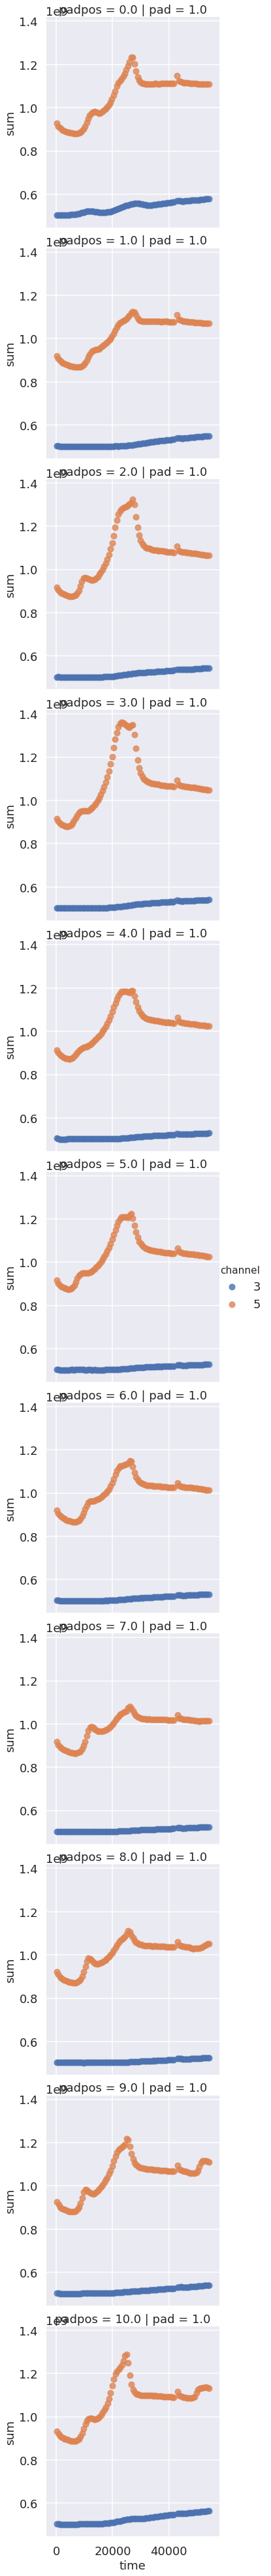

In [117]:
g = sns.lmplot(data=all_data.loc[all_data.pad==1,:], x='time', y='sum', hue='channel',row='padpos', fit_reg=False, sharey=True, col='pad')

In [93]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(scale=10, pad_ind=3):
    
#     n_frames, n_pos, h, w, n_chan = im_arr.shape
    h, w = im_height, im_width
    plt.close('all')
    pixels_per_um = 1/1.6
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min()-1000, pad_df.x.max()+1000])*pixels_per_um
    ylims = np.array([pad_df.y.min()-1000, pad_df.y.max()+1000])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_w = np.int(np.ceil(np.diff(xlims)))
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_arr = np.zeros((pad_h, pad_w, 3))
    rfp_norm = mpl_colors.Normalize(550*4, 800*4,clip=True)
    cfp_norm = mpl_colors.Normalize(4*1e3, 4*2e3,clip=True)
    pos_lims = (pad_df[['x','y']]*pixels_per_um).astype(np.int)
    def get_frame_arr(frame_ind):
        for pos in pos_list:
            x0, y0 = pos_lims.loc[pos,:].values - rel_mins[:,0]//1
        #     img_arr[y0:y0+1024,x0:x0+1024] = 1
            rfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==3),'fn'].values[0]
            cfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==5),'fn'].values[0]
            rfp_arr = skimage.filters.gaussian(skimage.io.imread(rfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
            cfp_arr = skimage.filters.gaussian(skimage.io.imread(cfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
#             rfp_arr = im_all[frame_ind, pos, :,:,1]#skimage.filters.gaussian(skimage.io.imread(rfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
#             cfp_arr = im_all[frame_ind, pos, :,:,2]#skimage.filters.gaussian(skimage.io.imread(cfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
            arr_rgb = np.zeros((w, h, 3))
            arr_rgb[:,:,0] = rfp_norm(rfp_arr)
            arr_rgb[:,:,1] = 0.75*cfp_norm(cfp_arr)
            arr_rgb[:,:,2] = 0.75*cfp_norm(cfp_arr)
            pad_arr[y0:y0+h,x0:x0+w] = arr_rgb
#         return img_arr
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    im = ax.imshow(skimage.transform.downscale_local_mean(pad_arr,(scale,scale,1)), animated=True, interpolation='none')
#     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()
    
    def animate(i):
        # Plot 
        get_frame_arr(i)
        im.set_array(skimage.transform.downscale_local_mean(pad_arr,(scale,scale,1)))
        
    # call the animator.  blit=True means only re-draw the parts that have changed.
#     writer = anm.HTMLWriter()
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=n_frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(scale=4, pad_ind=1)
anim.save('190725_pad1.gif', dpi=80, fps=15, writer='pillow')
# anim = write_movie(scale=8, pad_ind=3)
# anim.save('190725_pad3.gif', dpi=80, fps=15, writer='pillow')
# anim = write_movie(scale=8, pad_ind=4)
# anim.save('190725_pad4.gif', dpi=80, fps=15, writer='pillow')

In [26]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def label_fluor_im(im_arr, thresh_min=4e3):
    im_arr = im_arr / 65535
    w, h = im_arr.shape

    # Threshold
    thresh = skimage.filters.threshold_li(im_arr)
    thresh = np.max([thresh, thresh_min/65535])

    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_arr > thresh, selem)
    selem = skimage.morphology.square(6)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(mask_arrs, im_arrs):
    label_im, num = skimage.morphology.label(np.sum(mask_arrs,axis=0)>1, return_num=True)
#     num  = im_labeled.max()
    col_vec = np.arange(1,num+1)
    sfcfps = [np.mean(im_arrs[1][label_im == x]) for x in col_vec]
    mscarletis = [np.mean(im_arrs[0][label_im == x]) for x in col_vec]
    sizes = [np.sum(label_im == x) for x in col_vec]
    return mscarletis, sfcfps, sizes, col_vec, num



([], <a list of 0 Text yticklabel objects>)

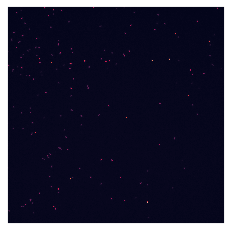

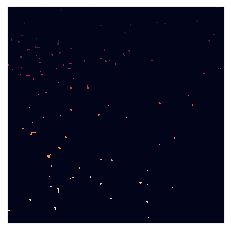

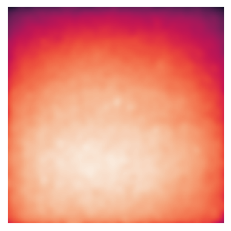

In [16]:

fn, pad, padpos, frame = files_df.loc[923,['fn','pad', 'padpos', 'frame']]
gb_ppf = files_df.loc[files_df.channel==3,:].groupby(['pad', 'padpos', 'frame'])
fn = gb_ppf.get_group((0,2,0)).loc[:,'fn'].values[0]
with Image.open(fn) as img:
    # Get image array
    _, _, im_arr = get_data_from_frame(img)
bg_arr = skimage.filters.gaussian(im_arr,8)
# fn_out  = mask_out_temp.format(pad, padpos, frame)
# with TiffWriter(fn_out, imagej=True, append=False) as tif:
fn = gb_ppf.get_group((3,4,10)).loc[:,'fn'].values[0]
with Image.open(fn) as img:
    # Get image array
    _, _, im_arr = get_data_from_frame(img)
    # Label image
    im_lab, col_num = label_fluor_im(im_arr-bg_arr)
    img_md = img_metadata_dict_full(img)
#             tif.save(im_lab.astype(np.uint16))
plt.imshow(im_arr)
plt.xticks([])
plt.yticks([])
plt.figure()
plt.imshow(im_lab)
plt.xticks([])
plt.yticks([])
plt.figure()
plt.imshow(bg_arr)
plt.xticks([])
plt.yticks([])

In [18]:
fn, pad, padpos, frame = files_df.loc[923,['fn','pad', 'padpos', 'frame']]
gb_ppf = files_df.loc[files_df.channel==5,:].groupby(['pad', 'padpos', 'frame'])
fn = gb_ppf.get_group((0,2,0)).loc[:,'fn'].values[0]
with Image.open(fn) as img:
    # Get image array
    _, _, im_arr = get_data_from_frame(img)
bg_arr = skimage.filters.gaussian(im_arr,8)

def mask_maker_worker(sub_fdf, bg_arr):
    mask_out_temp = './worker_outputs/mask_pad{}_padpos{}_frame{}_channel{}.tif'
    for ind in sub_fdf.index:
        fn, pad, padpos, frame, channel = sub_fdf.loc[ind,['fn','pad', 'padpos', 'frame','channel']]
        if channel==0:
            continue
        if channel==3:
            min_thresh = 2.2e3
        if channel==5:
            min_thresh = 4e3
        fn_out  = mask_out_temp.format(pad, padpos, frame, channel)
        with Image.open(fn) as img:
            # Get image array
            _, _, im_arr = get_data_from_frame(img)
            # Label image
            im_lab, col_num = label_fluor_im(im_arr, min_thresh)
            img_md = img_metadata_dict_full(img)
        with TiffWriter(fn_out, imagej=True, append=False) as tif:
            tif.save(im_lab.astype(np.uint16))

jobs = []
n_proc = 4
# chan_df = files_df.loc[files_df.channel==5,:]
for i in np.arange(n_proc):
    p = multiprocessing.Process(target=mask_maker_worker, 
                                args=(files_df[i::n_proc].copy(),bg_arr.copy()))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

Done!


In [43]:
def analyze_colonies_worker(df_list, csv_out):
    column_names = ('mscarlet-i', 'sfcfp','col_size','colony','time', 'pad', 'padpos', 'frame')
    colony_df = pd.DataFrame(columns = column_names)
    mask_out_temp = './worker_outputs/mask_pad{}_padpos{}_frame{}_channel{}.tif'
    for sub_df in df_list:
        fn_dict = dict(zip(sub_df.channel, sub_df.fn))
        pad, padpos, frame, im_time = sub_df.iloc[0,:][['pad','padpos','frame','time']]
        mask_fns  = [mask_out_temp.format(pad, padpos, frame, xx) for xx in [3,5]]
        mask_arrs = [skimage.io.imread(mask_fn) for mask_fn in mask_fns]
        im_arrs = [skimage.io.imread(img_fn) for img_fn in sub_df.fn.values]
        rfp_vec, cfp_vec, size_vec, col_vec, n_colonies = get_fluors(mask_arrs, im_arrs)
        img_metadata = [pad, padpos, frame, im_time]
        pad_vec, padpos_vec, frame_vec, time_vec = [np.ones(n_colonies)*xx for xx in img_metadata]
        update_vecs = [rfp_vec, cfp_vec, size_vec, col_vec, time_vec, pad_vec, padpos_vec, frame_vec]
        colony_update_df = pd.DataFrame(dict(zip(column_names, update_vecs)))
        colony_df = colony_df.append(colony_update_df, ignore_index=True)
        colony_df.index = np.arange(colony_df.shape[0])
    colony_df.to_csv(csv_out, index=False)

jobs = []
n_proc = 4
out_files = ['./worker_outputs/analyze_colonies_part{}.csv'.format(xx) for xx in np.arange(n_proc)]
gb_pp = files_df.loc[files_df.channel>0,:].groupby(['pos', 'frame'])
gb_keys = list(gb_pp.groups.keys())
df_list = []
for proc_i in np.arange(n_proc):
    df_list.append([gb_pp.get_group(key) for key in gb_keys[proc_i::n_proc]])

for i in np.arange(n_proc):
    p = multiprocessing.Process(target=analyze_colonies_worker, 
                                args=(df_list[i],out_files[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

Done!


In [43]:
def analyze_colonies_worker(df_list, csv_out):
    column_names = ('mscarlet-i', 'sfcfp','col_size','colony','time', 'pad', 'padpos', 'frame')
    colony_df = pd.DataFrame(columns = column_names)
    mask_out_temp = './worker_outputs/mask_pad{}_padpos{}_frame{}_channel{}.tif'
    for sub_df in df_list:
        fn_dict = dict(zip(sub_df.channel, sub_df.fn))
        pad, padpos, frame, im_time = sub_df.iloc[0,:][['pad','padpos','frame','time']]
        mask_fns  = [mask_out_temp.format(pad, padpos, frame, xx) for xx in [3,5]]
        mask_arrs = [skimage.io.imread(mask_fn) for mask_fn in mask_fns]
        im_arrs = [skimage.io.imread(img_fn) for img_fn in sub_df.fn.values]
        rfp_vec, cfp_vec, size_vec, col_vec, n_colonies = get_fluors(mask_arrs, im_arrs)
        img_metadata = [pad, padpos, frame, im_time]
        pad_vec, padpos_vec, frame_vec, time_vec = [np.ones(n_colonies)*xx for xx in img_metadata]
        update_vecs = [rfp_vec, cfp_vec, size_vec, col_vec, time_vec, pad_vec, padpos_vec, frame_vec]
        colony_update_df = pd.DataFrame(dict(zip(column_names, update_vecs)))
        colony_df = colony_df.append(colony_update_df, ignore_index=True)
        colony_df.index = np.arange(colony_df.shape[0])
    colony_df.to_csv(csv_out, index=False)

jobs = []
n_proc = 4
out_files = ['./worker_outputs/analyze_colonies_part{}.csv'.format(xx) for xx in np.arange(n_proc)]
gb_pp = files_df.loc[files_df.channel>0,:].groupby(['pos', 'frame'])
gb_keys = list(gb_pp.groups.keys())
df_list = []
for proc_i in np.arange(n_proc):
    df_list.append([gb_pp.get_group(key) for key in gb_keys[proc_i::n_proc]])

for i in np.arange(n_proc):
    p = multiprocessing.Process(target=analyze_colonies_worker, 
                                args=(df_list[i],out_files[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

Done!


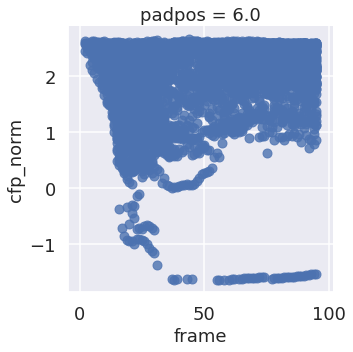

In [112]:
# colonies_df = pd.concat([pd.read_csv(xx) for xx in out_files],ignore_index=True)
# colonies_df.index = np.arange(colonies_df.shape[0])
colonies_df.loc[:,'cfp_norm'] = np.log10(colonies_df['sfcfp'] / colonies_df['col_size'])
# colonies_df.loc[:,'rfp_norm'] = colonies_df['mscarlet-i'] / colonies_df['col_size']
g = sns.lmplot(data=colonies_df.loc[(colonies_df.pad==1)&(colonies_df.padpos==6),:], 
               x='frame', y='cfp_norm', row='padpos', fit_reg=False)

([], <a list of 0 Text yticklabel objects>)

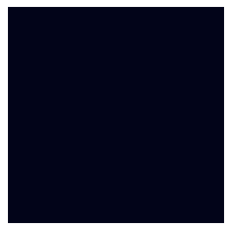

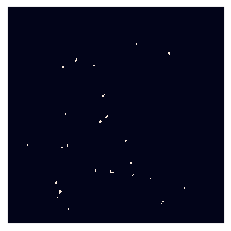

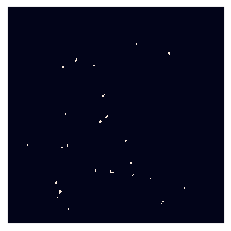

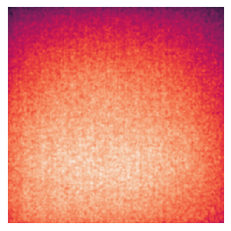

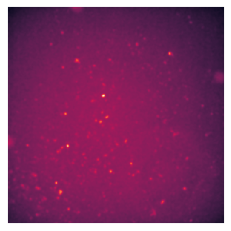

In [108]:
gb_ppf = files_df.groupby(['pad','padpos','frame'])
pad, padpos, frame = 1, 6, 8
sub_df = gb_ppf.get_group((pad, padpos, frame))
mask_out_temp = './worker_outputs/mask_pad{}_padpos{}_frame{}_channel{}.tif'
mask_fns = [mask_out_temp.format(pad, padpos, frame, xx) for xx in [3,5]]
masks = [skimage.io.imread(fn) for fn in mask_fns]
imgs = [skimage.io.imread(fn) for fn in sub_df.fn.values[1:]]
plt.imshow(masks[0]>1)
plt.xticks([]);plt.yticks([])
plt.figure()
plt.imshow(masks[1]>1)
plt.xticks([]);plt.yticks([])
plt.figure()
plt.imshow(np.sum(masks,axis=0)>1)
plt.xticks([]);plt.yticks([])
plt.figure()
plt.imshow(skimage.filters.gaussian(imgs[0],2,preserve_range=True))
plt.xticks([]);plt.yticks([])
# _ = plt.hist(imgs[0].flatten(),bins=200)
plt.figure()
plt.imshow(skimage.filters.gaussian(imgs[1],2,preserve_range=True))
plt.xticks([]);plt.yticks([])
# _ = plt.hist(imgs[1].flatten(),bins=200)

In [109]:
sub_df

,pos,padpos,pad,frame,channel,fn,time
1386,14,6,1,8,0,../data/Pos29/img_000000008_0_000.tif,4643.0
1387,14,6,1,8,3,../data/Pos29/img_000000008_3_000.tif,4646.0
1388,14,6,1,8,5,../data/Pos29/img_000000008_5_000.tif,4649.0
